In [36]:
import carla

client = carla.Client('localhost', 2000)
client.set_timeout(10.0)
world = client.get_world()

In [40]:
vehicles = world.get_actors().filter('vehicle.*')
print(f"Number of vehicles: {len(vehicles)}")


Number of vehicles: 30


In [42]:
import time
def attach_collision_sensor(vehicle, vehicle_data):
    blueprint_library = world.get_blueprint_library()
    collision_sensor_bp = blueprint_library.find('sensor.other.collision')
    collision_sensor = world.spawn_actor(
        collision_sensor_bp,
        carla.Transform(),
        attach_to=vehicle
    )
    # Get vehicle behavior (assuming 'role_name' was set during spawning)
    role_name = vehicle.attributes.get("role_name", "Unknown")  # Default to "Unknown" if not set
    
    collision_cooldown = {}  # Store last collision timestamp per vehicle
    def on_collision(event):
        vehicle_id = vehicle.id
        COLLISION_COOLDOWN_TIME = 2  # Only log one collision per 2 seconds per vehicle
        current_time = time.time()
        # Check if this vehicle has a cooldown timer
        if vehicle_id in collision_cooldown:
            if current_time - collision_cooldown[vehicle_id] < COLLISION_COOLDOWN_TIME:
                return  # Skip logging this collision
        other_actor = event.other_actor
        print(f"Collision detected for Vehicle {vehicle_id} with {other_actor.type_id}")
        if vehicle_id in vehicle_data:
            vehicle_data[vehicle_id]["collision_count"] += 1
            vehicle_data[vehicle_id]["behavior"] = role_name  # Store behavior in data log
            collision_cooldown[vehicle_id] = current_time  # Update cooldown time
    
    collision_sensor.listen(on_collision)
    return collision_sensor

# Get all vehicles spawned by generate_traffic.py
vehicles = world.get_actors().filter('vehicle.*')

# Attach sensors
vehicle_data = {}
collision_sensors = []

for vehicle in vehicles:
    #Get vehicle behavior from role_name (set during spawning)
    role_name = vehicle.attributes.get("role_name", "Unknown")  # Default to "Unknown" if missing
    
    vehicle_data[vehicle.id] = {
        "speeds": [],
        "distance_traveled": 0.0,
        "last_location": vehicle.get_location(),
        "collision_count": 0,
        "behavior": role_name  # Store vehicle behavior (Reckless/Normal)
    }
    sensor = attach_collision_sensor(vehicle, vehicle_data)
    collision_sensors.append(sensor)


In [44]:
import time

start_time = time.time()


while time.time() - start_time < 60:  # Run for 1 minute
    world.tick()  # Advance simulation
    for vehicle in vehicles:
        velocity = vehicle.get_velocity()
        speed = 3.6 * ((velocity.x**2 + velocity.y**2 + velocity.z**2) ** 0.5)  # Convert to km/h

        if vehicle.id not in vehicle_data:
            vehicle_data[vehicle.id] = {
                "speeds": [],
                "distance_traveled": 0.0,
                "last_location": vehicle.get_location(),
                "collision_count": 0,
                "behavior": vehicle.attributes.get("role_name", "Unknown")  # Track behavior
            }

        # Update speed
        vehicle_data[vehicle.id]["speeds"].append(speed)

        # Calculate distance traveled
        current_location = vehicle.get_location()
        last_location = vehicle_data[vehicle.id]["last_location"]
        distance = ((current_location.x - last_location.x)**2 +
                    (current_location.y - last_location.y)**2 +
                    (current_location.z - last_location.z)**2) ** 0.5
        vehicle_data[vehicle.id]["distance_traveled"] += distance
        vehicle_data[vehicle.id]["last_location"] = current_location


Collision detected for Vehicle 226 with static.sidewalk
Collision detected for Vehicle 221 with vehicle.mercedes.coupe
Collision detected for Vehicle 213 with vehicle.citroen.c3
Collision detected for Vehicle 214 with static.pole
Collision detected for Vehicle 217 with static.static
Collision detected for Vehicle 225 with static.fence
Collision detected for Vehicle 215 with vehicle.audi.etron
Collision detected for Vehicle 228 with static.vegetation
Collision detected for Vehicle 221 with static.vegetation
Collision detected for Vehicle 216 with static.building
Collision detected for Vehicle 224 with static.trafficsign
Collision detected for Vehicle 214 with static.pole
Collision detected for Vehicle 217 with static.building
Collision detected for Vehicle 228 with static.sidewalkCollision detected for Vehicle 221 with static.vegetation

Collision detected for Vehicle 216 with static.building
Collision detected for Vehicle 219 with static.car
Collision detected for Vehicle 214 with stat

In [46]:
import pandas as pd

processed_data = []
for vehicle_id, data in vehicle_data.items():
    avg_speed = sum(data["speeds"]) / len(data["speeds"]) if data["speeds"] else 0
    max_speed = max(data["speeds"], default=0)
    processed_data.append({
        "Vehicle ID": vehicle_id,
        "Behavior": data.get("behavior", "Unknown"),  # Include agent behavior (Reckless/Normal)
        "Average Speed (km/h)": avg_speed,
        "Max Speed (km/h)": max_speed,
        "Distance Traveled (m)": data["distance_traveled"],
        "Collisions": data["collision_count"]
    })

df = pd.DataFrame(processed_data)
df.to_csv("Reckless_vehicle_metrics.csv", index=False)


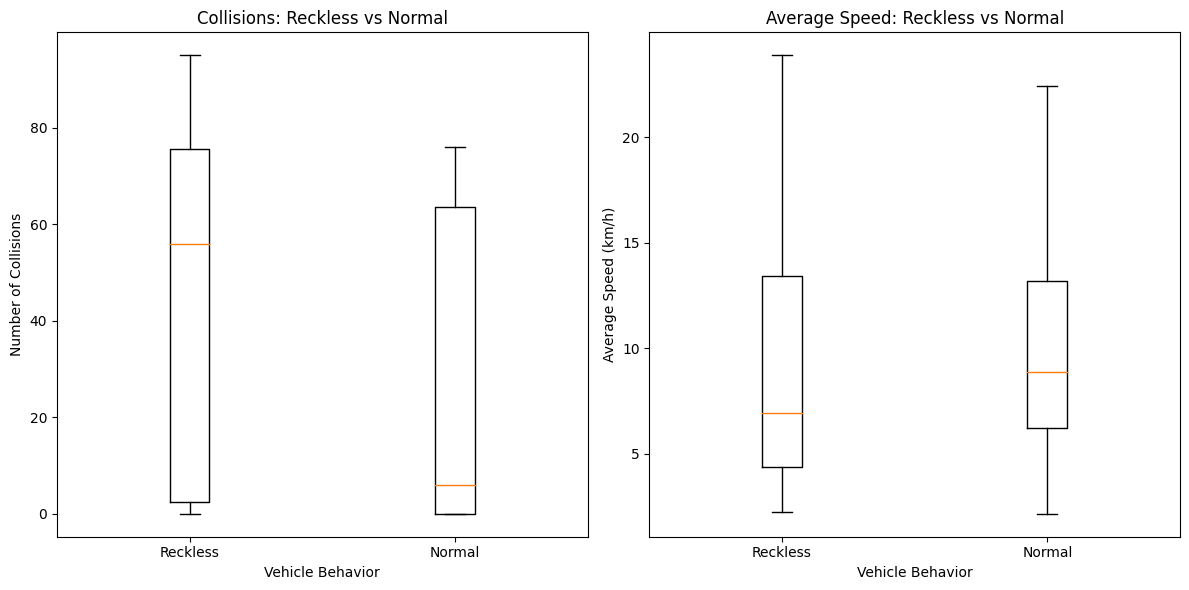

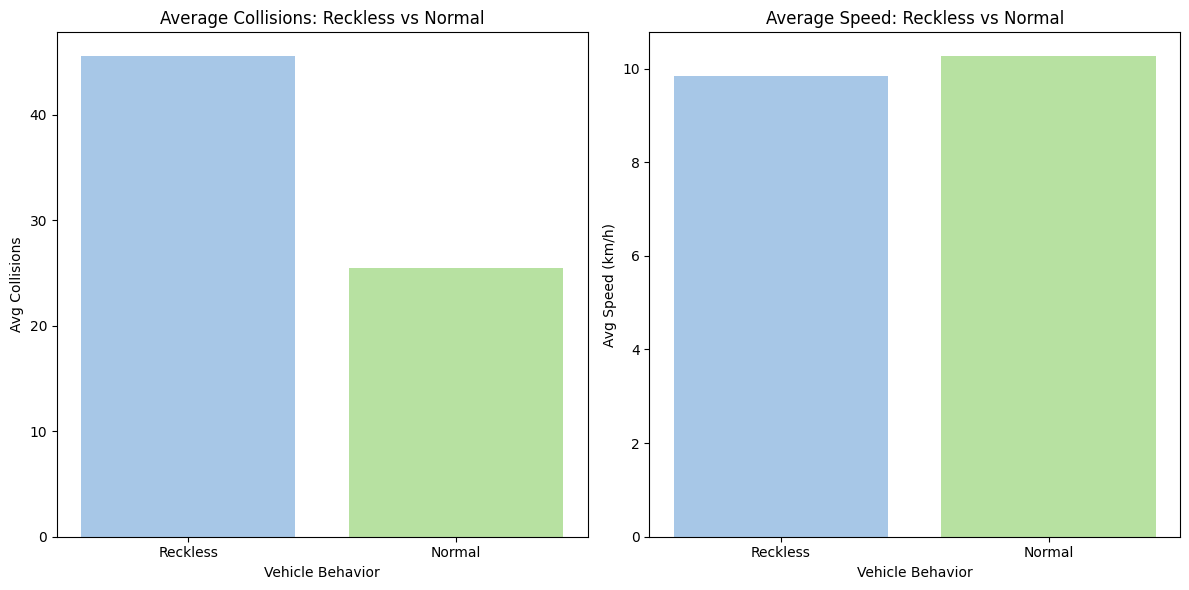

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("Reckless_vehicle_metrics.csv")

light_blue = "#A7C7E7"  # Soft pastel blue
light_green = "#B7E1A1"  # Soft pastel green

# Separate data for Reckless and Normal vehicles
reckless_df = df[df["Behavior"] == "Reckless"]
normal_df = df[df["Behavior"] == "Normal"]

# Create subplots for Boxplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Boxplot 1: Collisions Comparison
axs[0].boxplot([reckless_df["Collisions"], normal_df["Collisions"]], labels=['Reckless', 'Normal'])
axs[0].set_title("Collisions: Reckless vs Normal")
axs[0].set_xlabel("Vehicle Behavior")
axs[0].set_ylabel("Number of Collisions")

# Boxplot 2: Average Speed Comparison
axs[1].boxplot([reckless_df["Average Speed (km/h)"], normal_df["Average Speed (km/h)"]], labels=['Reckless', 'Normal'])
axs[1].set_title("Average Speed: Reckless vs Normal")
axs[1].set_xlabel("Vehicle Behavior")
axs[1].set_ylabel("Average Speed (km/h)")

plt.tight_layout()
plt.show()

# Create Bar Charts for Average Values
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Compute mean values
avg_collisions = [reckless_df["Collisions"].mean(), normal_df["Collisions"].mean()]
avg_speed = [reckless_df["Average Speed (km/h)"].mean(), normal_df["Average Speed (km/h)"].mean()]

# Bar Chart 1: Average Collisions
axs[0].bar(["Reckless", "Normal"], avg_collisions, color=[light_blue, light_green])
axs[0].set_title("Average Collisions: Reckless vs Normal")
axs[0].set_xlabel("Vehicle Behavior")
axs[0].set_ylabel("Avg Collisions")

# Bar Chart 2: Average Speed
axs[1].bar(["Reckless", "Normal"], avg_speed, color=[light_blue, light_green])
axs[1].set_title("Average Speed: Reckless vs Normal")
axs[1].set_xlabel("Vehicle Behavior")
axs[1].set_ylabel("Avg Speed (km/h)")

plt.tight_layout()
plt.show()
